## Power Curtailments

Some or all of the turbines within a wind farm may need to be shut down to mitigate issues associated with turbine loading, export to the grid, or certain planning conditions. Turbine loading is influenced by the wake effects from nearby machines.  For some wind farms with particularly close machine spacing, it may be necessary to shut down certain turbines for certain wind conditions.  This is referred to as wind sector management, and will generally result in a reduction in the energy production of the wind farm.


### Road map: 
* Load the power curtailments dataset (provided separately in a CSV file).
* Visualize the data.
* Detect potential outliers.
* Analyse the temporal behaviour of outliers to detect potential power curtailments.

In [27]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Load Data

In [29]:
# read file
cwd = os.getcwd()
path = os.path.join(cwd, 'data')
data_file = 'powercurtailments.csv'
data_csv = os.path.join(path, data_file)
#cols = ['Time','Asset','Power','WindSpeed']
df = pd.read_csv(data_csv)
# df['datetime'] = pd.to_datetime(df['Time'], unit='s')
df.set_index('Time', drop=True, inplace=True)

### Explore data

In [30]:
df.head()

,Unnamed: 0,Asset,Power,WindSpeed
Time,,,,
0.0,1,1,NaN,NaN
0.0,2,2,NaN,NaN
0.0,3,3,NaN,NaN
0.0,4,4,NaN,NaN
0.0,5,5,0.010745,0.040359


In [31]:
# df Shape
print('shape= {}'.format(df.shape))

shape= (1301197, 4)


In [32]:
# Data types
df.dtypes

Unnamed: 0      int64
Asset           int64
Power         float64
WindSpeed     float64
dtype: object

In [33]:
# NAN count
df.isnull().sum()

Unnamed: 0         0
Asset              0
Power         477980
WindSpeed     282106
dtype: int64

In [7]:
list(df.Asset.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

### Data Visualization

In [34]:
# SELECT ASSET
a=13
df_plot = df[df.Asset==a]

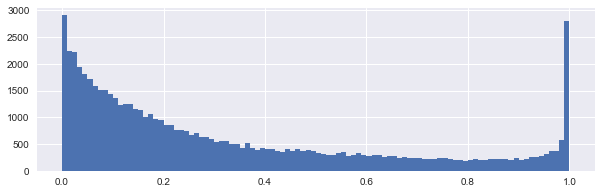

In [35]:
# POWER HISTOGRAM
fig, ax = plt.subplots( figsize=(10,3) )
df_plot['Power'].hist(bins=100);

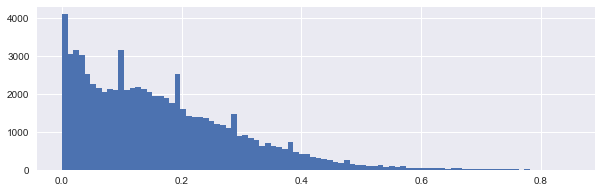

In [36]:
# WIND HISTOGRAM
fig, ax = plt.subplots( figsize=(10,3) )
df_plot['WindSpeed'].hist(bins=90);

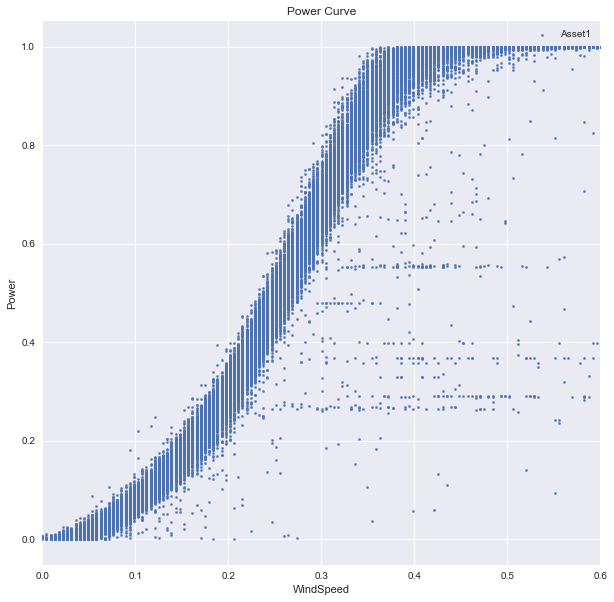

In [37]:
# POWER CURVE
fig, ax = plt.subplots( figsize=(10,10) )
x ='WindSpeed'
y ='Power'
df_plot.plot.scatter(x,y, ax=ax, marker ='.', label='Asset1');
ax.set_title('Power Curve');
ax.set_xlim(0, .6);

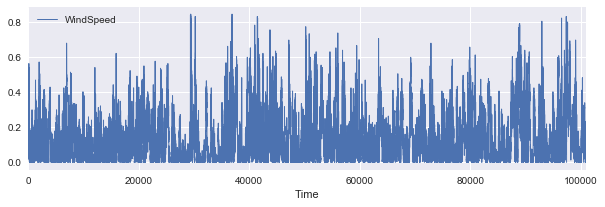

In [40]:
## TIME Series
dfA= df_plot.copy()
feature = 'WindSpeed'
fig, (ax1) = plt.subplots( figsize=(10,3) )
dfA[feature].plot(ax=ax1, lw=1, legend=feature);

### DATA PREPROCESS

In [43]:
options = { 'test_score' :          0, # model error metric wrt test data 
            'historical_pwr':       0, # y_pred vs y_test on 5 months SCADA (time series)  
            'validation_score' :    0, # model error metrics wrt Validation data
            'validation_pwr'   :    0, # y_pred vs y_val on 24 hr scada dates (time-series)
            'pwr_curve_suboptimal': 0, ## pwr_curve with sub-optimal data pairs 
            'pwr_curve_predicted':  0, ## ML predicted pwr_curve
            'pwr_curve_residuals':  1, ## Show outliers on Train_data
            'pwr_curve_all_resid':  0, ## Show outliers on Train_data
            'residuals_quantiles':  1, ## Show residuals matrix and histogram
            }

Error Quantiles per asset
            Q90       Q95       Q97        Q99
asset                                         
1      2.262282  4.374591  6.682550  25.536306
2      2.651161  4.199972  6.243500  16.051974
3      1.840972  3.381736  4.725267  13.234482
4      2.175661  3.887083  5.537632  16.101840
5      3.117261  5.426634  7.881326  26.572495
6      1.872990  3.656500  5.263259  20.872507
7      2.248431  3.526159  5.121438  13.626831
8      2.047197  3.422149  4.717980  12.858601
9      2.299903  4.137721  6.072836  22.100587
10     2.038062  3.557774  4.919502  11.991952
11     2.130397  3.603857  5.641658  19.200475
12     2.053494  3.195040  4.575805  12.358340
13     2.158680  3.720950  5.141894  12.819524


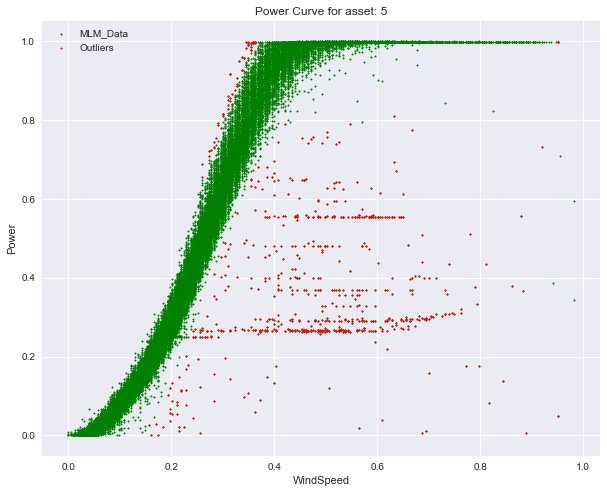

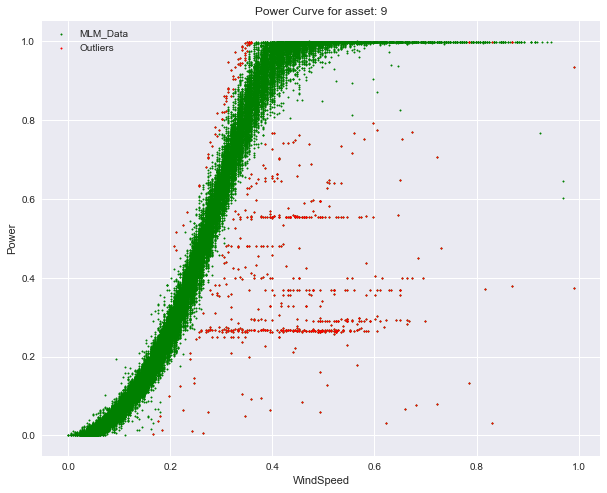

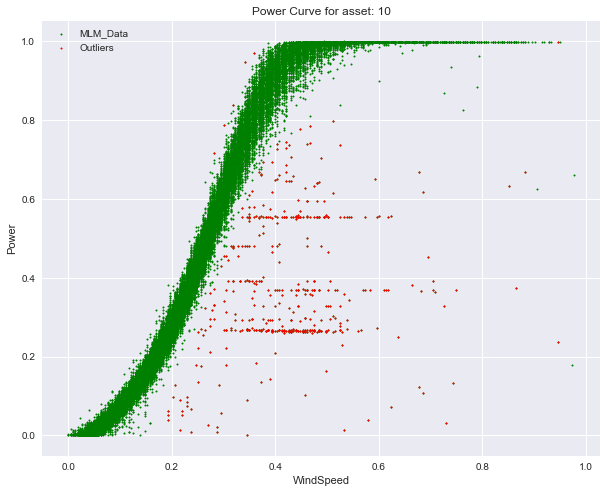

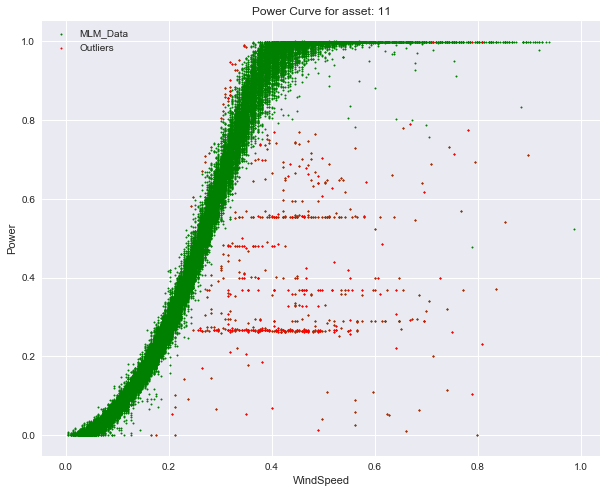

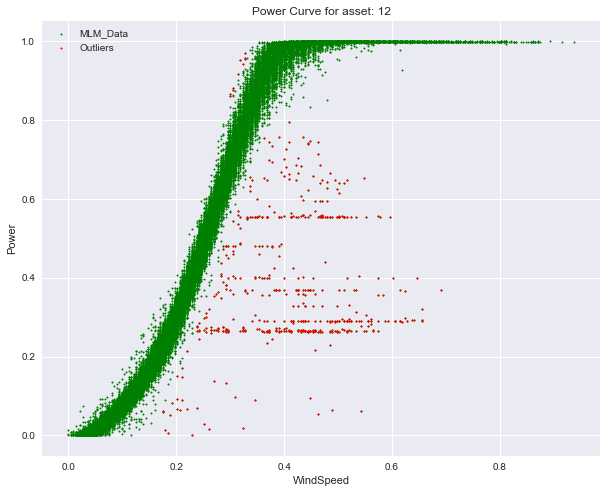

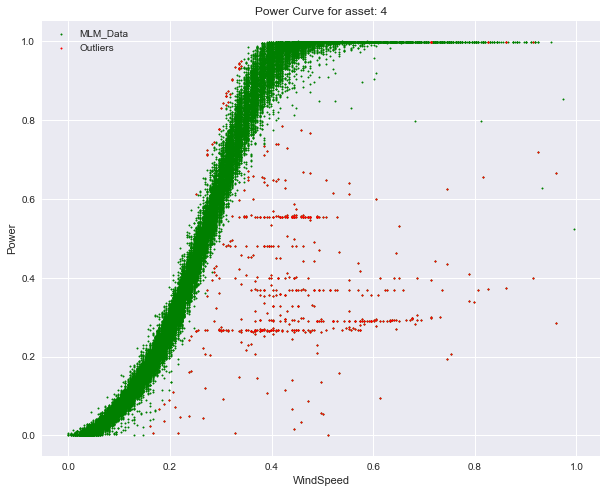

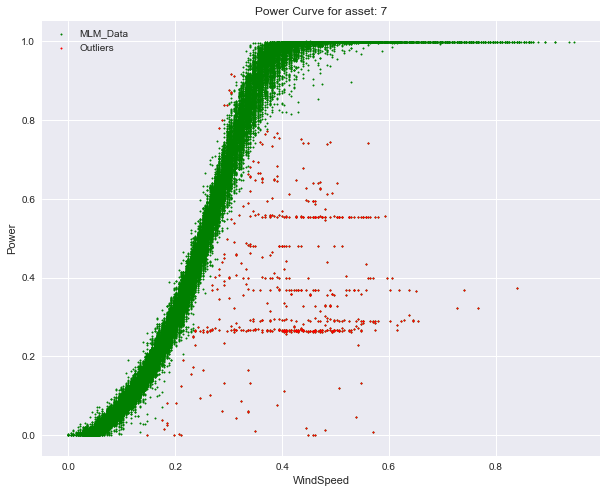

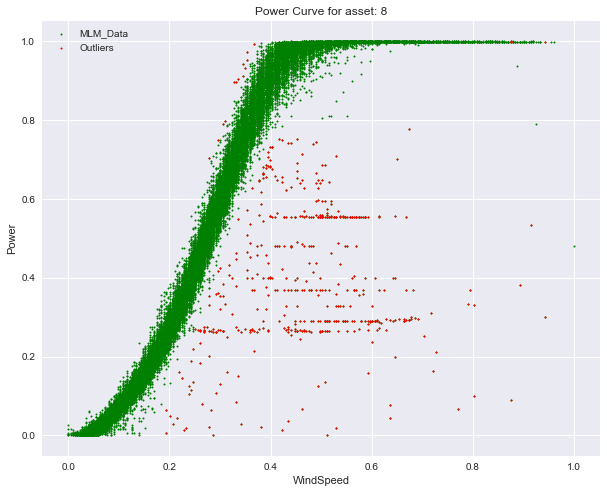

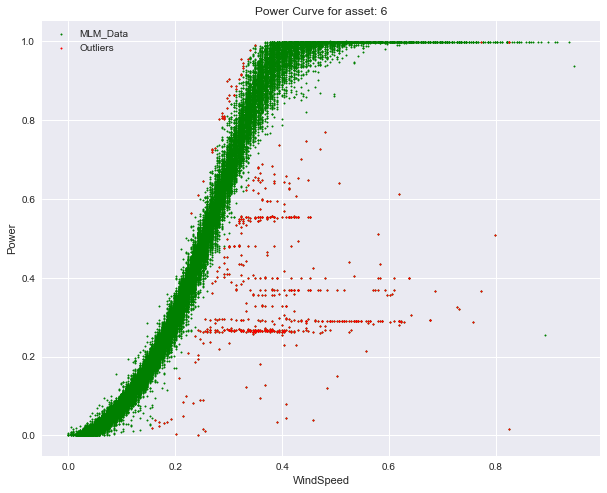

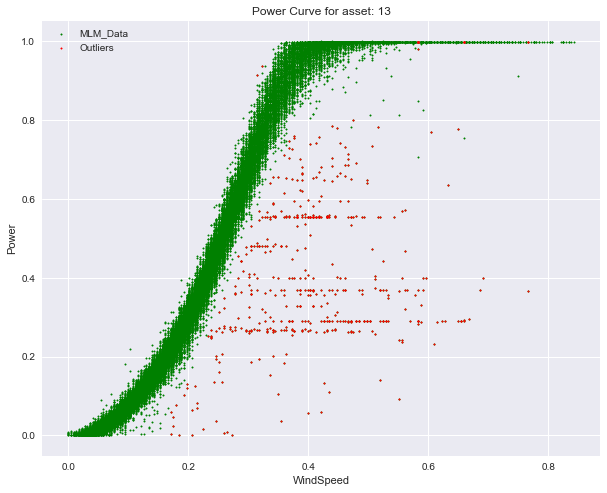

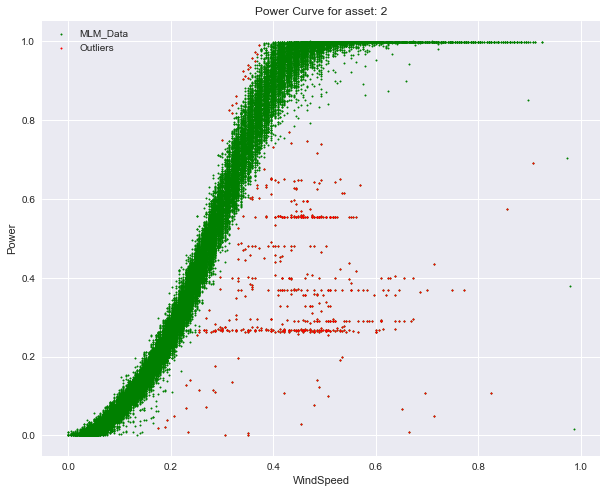

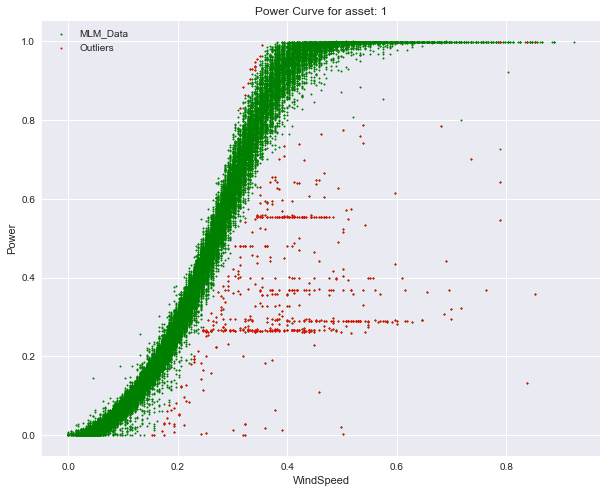

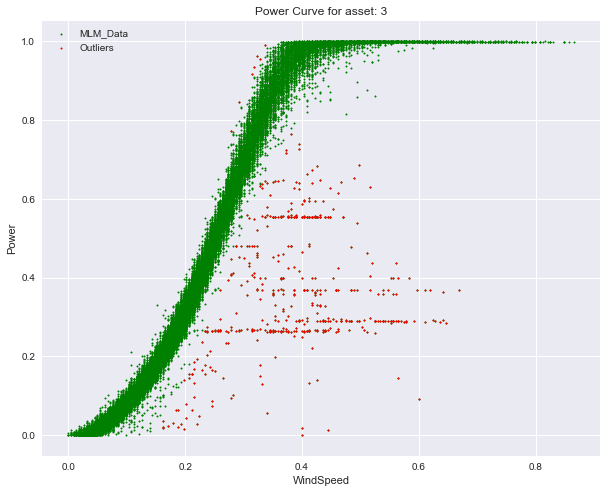

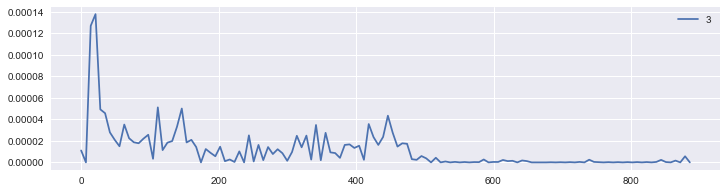

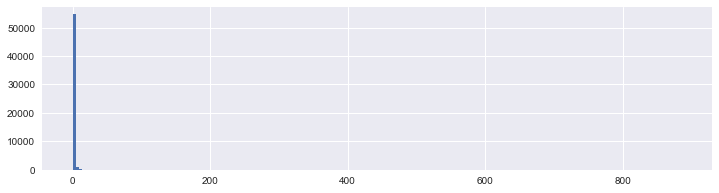

In [46]:
def data_preprocessing(df_hist, options):
    ''' Data cleaning using preliminar ML model '''
    
    df_hist = df_hist.dropna(axis=0)  # remove any row with nans
    
    # ******************************************
    # CLEAN HISTORICAL scada USING ML and residuals

    # Define features for model training and target label    
    features = ['WindSpeed']
    target = 'Power' 

    # Loop over assets
    assets = df_hist.Asset.unique()
    for i, asset in enumerate(assets):
        asset_mask = df_hist.Asset==asset

        # Data definition for ML training
        y_data = df_hist.loc[asset_mask, target]
        x_data = df_hist.loc[asset_mask, features]
        x_train, x_test, y_train, y_test, model = ML_model(x_data,y_data) #FUN Call
        model.fit(x_train, y_train)

        y_pred = model.predict(x_train)
        
        # calculate squared error
        ## **********************************************************
        error= 1000*(y_pred - y_train)**2
        error_lim = 25.0 # <<<<<  error limit for valid values
        ## ***********************************************************
        
        if i == 0:
            df_train = x_train.copy()
            df_train[target] = y_train
            df_train['asset'] = asset
            df_train['pred_pwr'] = y_pred
            df_train['error'] = error
            df_train['valid'] = df_train.error <= error_lim
        else:
            df_concat = x_train.copy()
            df_concat[target] = y_train
            df_concat['asset'] = asset
            df_concat['pred_pwr'] = y_pred
            df_concat['error'] = error
            df_concat['valid'] = df_concat.error <= error_lim            
            df_train = pd.concat([df_train, df_concat], axis=0)

        if i == 0:
            df_test = x_test.copy()
            df_test[target] = y_test
            df_test['asset'] = asset                             
        else:
            df_concat2 = x_test.copy()
            df_concat2[target] = y_test
            df_concat2['asset'] = asset                     
            df_test = pd.concat([df_test, df_concat2], axis=0)   
            
        # plot Power Curves and residuals

        if options['pwr_curve_residuals']:   
            
            dfA = df_hist[df_hist.Asset==asset]
            dfB = df_train[df_train.asset==asset]
            dfB_remove = dfB[dfB.valid==False]
            dfC = df_test[df_test.asset==asset]          
            
            fig, (ax2) = plt.subplots(1,1, figsize=(10,8) )
            s=10 # marker size
            dfB.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='g', label='MLM_Data')
            dfB_remove.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='r', label='Outliers')  
            ax2.set_title('Power Curve for asset: '+ str(asset))

            
        # SHOW Power Curves and sub_optimal datapoints
        
        if options['pwr_curve_suboptimal']:   
            df_A = df_hist[df_hist.Asset==asset]
            
            # Remove near-zero Power values at windspeed higher than 0.1
            mask = (df_A.Power < 0.001) & (df_A.WindSpeed > 0.10) 
            df_B = df_A[mask]
            # Remove sub-optimal Power values 
            mask = (df_A.Power < 0.95) & (df_A.WindSpeed > 0.35) 
            df_C = df_A[mask]

            fig, (ax1) = plt.subplots(1,1, figsize=(7,5) )
            s=2 # marker size
            df_A.plot.scatter('WindSpeed','Power', ax=ax1, marker='.',s=1,c='g',label='OK')
            df_C.plot.scatter('WindSpeed','Power', ax=ax1, marker='+',s=15,c='m',label ='NOK under-rated-pwr')    
            df_B.plot.scatter('WindSpeed','Power', ax=ax1, marker='x',s=15,c='b',label='NOK zero-pwr')
            ax1.set_title('Power Curve for asset: '+ str(asset))
            
        # plot PREDICTED Power Curves 
        
        if options['pwr_curve_predicted']:   
            df_A = df_train[df_train.Asset==asset]
            fig, (ax1) = plt.subplots(1,1, figsize=(9,6) )
            df_A.plot.scatter('WindSpeed', 'pred_pwr', ax=ax1, marker='.', s=10, c='k')
            ax1.set_title('Power Curve for asset: '+ str(asset))
            ax1.set_ylabel('Predicted Power')
            
    ## Collect residuals        
    df_residuals = df_train[df_train.valid==False]  
    
    if options['pwr_curve_all_resid']:   
        dfA = df_train
        dfB = df_residuals 
            
        fig, (ax2) = plt.subplots(1,1, figsize=(10,8) )
        s=10 # marker size
        dfA.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='g', label='MLM_Data')
        dfB.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='r', label='Outliers')  
        ax2.set_title('Power Curve for asset: '+ str(asset))    
    

    ## RESIDUALS INSPECTION (visual aid during development)
    if options['residuals_quantiles']:
        # print ('Descriptive stats for error dataframe')
        # print ( df_train.pivot( columns='asset', values='error').describe() )
        df_quantiles = pd.DataFrame()
        df_quantiles['Q90']= df_train.pivot( columns='asset', values='error').quantile(.90)
        df_quantiles['Q95']= df_train.pivot( columns='asset', values='error').quantile(.95)
        df_quantiles['Q97']= df_train.pivot( columns='asset', values='error').quantile(.97)
        df_quantiles['Q99']= df_train.pivot( columns='asset', values='error').quantile(.99)
        print ( 'Error Quantiles per asset')
        print (df_quantiles)
        
        # visualize residuals kde
        ast= asset
        fig, ax1 = plt.subplots(figsize=(12,3) )
        sns.kdeplot(df_train.loc[df_train.asset==ast,'error'], label=ast, ax=ax1)
        
        # WIND HISTOGRAM
        fig, ax = plt.subplots( figsize=(12,3) )
        df_train.loc[df_train.asset==ast,'error'].hist(bins=200)
        
    # DATA CLEANING 
    # set execute to 1 to remove outliers from ml model training data
    execute = 0
    if execute: 
        # Remove residuals higher than 1.0
        #df_train =  df_train[df_train.valid==True]
        
        # Remove near-zero Power values at windspeed higher than 0.1
        mask = np.invert((df_train.WTURPower < 0.001) & (df_train.WNACWindSpeed > 0.10)) 
        df_train = df_train[mask]

        # Remove sub-optimal Power values 
        mask = np.invert((df_train.WTURPower < 0.95) & (df_train.WNACWindSpeed > 0.35)) 
        df_train = df_train[mask]
    
    return df_residuals, df_train

df_residuals, df_train = data_preprocessing(df, options)

In [47]:
df_residuals.head()

,WindSpeed,Power,asset,pred_pwr,error,valid
Time,,,,,,
37672.0,0.650224,0.289920,5,0.933192,413.799108,False
36715.0,0.269058,0.264731,5,0.519860,65.090648,False
55654.0,0.497758,0.329302,5,0.938657,371.313879,False
37564.0,0.502242,0.556600,5,0.943616,149.781572,False
37638.0,0.551570,0.286071,5,0.954878,447.301876,False


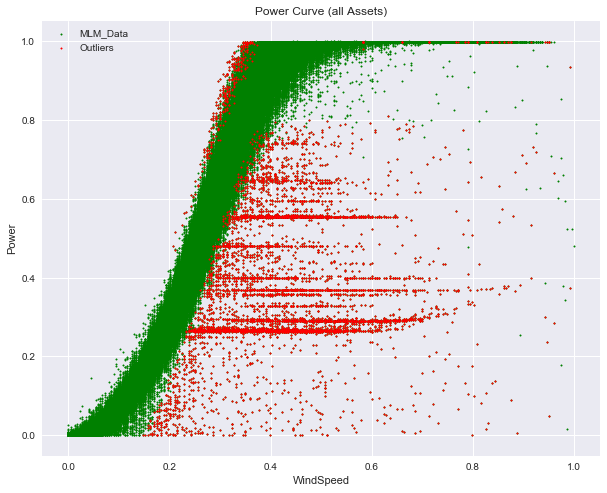

In [48]:
dfA = df_train
dfB = df_residuals 
            
fig, (ax2) = plt.subplots(1,1, figsize=(10,8) )
s=10 # marker size
dfA.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='g', label='MLM_Data')
dfB.plot.scatter('WindSpeed', 'Power', ax=ax2, marker='.', s=s, c='r', label='Outliers')  
ax2.set_title('Power Curve (all Assets)') ;

### Method 1: Curtailments detection using histogram

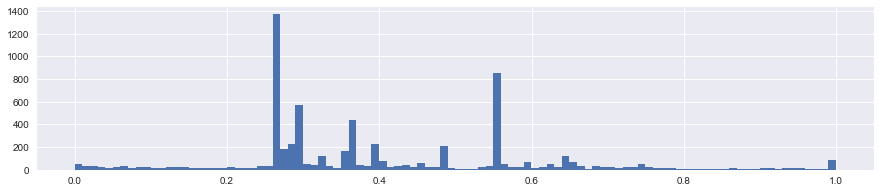

In [49]:
# POWER HISTOGRAM
fig, ax = plt.subplots( figsize=(15,3) )
df_residuals['Power'].hist(bins=100);

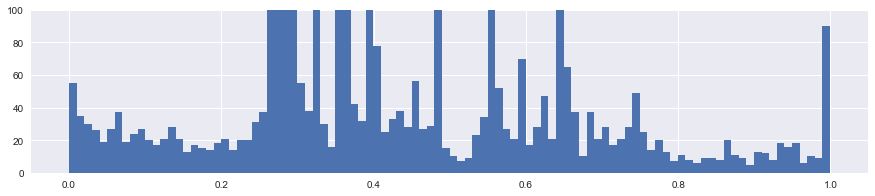

In [50]:
# POWER HISTOGRAM
fig, ax = plt.subplots( figsize=(15,3) )
df_residuals['Power'].hist(bins=100)
ax.set_ylim([0,100]);

In [51]:
# Get bins with highest frequency

freq, bin_edge = np.histogram(df_residuals['Power'], bins=100)

## *****************Freq Threshold ************
mask = freq > 100
## *******************************************

mask = np.append(mask, False)
pwr_curt_L = bin_edge[mask]
pwr_curt_R = pwr_curt_L + bin_edge[1] - bin_edge[0]

for i in range(0, len(pwr_curt_L)):
    if i ==0:
        mask = (df_residuals['Power'] >= pwr_curt_L[i]) & (df_residuals['Power'] <= pwr_curt_R[i])
    else:
        temp_mask = (df_residuals['Power'] >= pwr_curt_L[i]) & (df_residuals['Power'] <= pwr_curt_R[i])
        mask = np.logical_or(mask, temp_mask)

df_curt = df_residuals[mask]

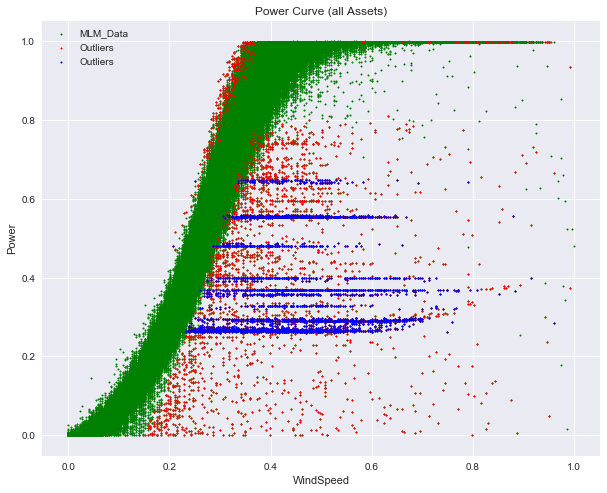

In [52]:
dfA = df_train
dfB = df_residuals
dfC = df_curt
            
fig, (ax) = plt.subplots(1,1, figsize=(10,8) )
s=10 # marker size
dfA.plot.scatter('WindSpeed', 'Power', ax=ax, marker='.', s=s, c='g', label='MLM_Data')
dfB.plot.scatter('WindSpeed', 'Power', ax=ax, marker='.', s=s, c='r', label='Outliers')
dfC.plot.scatter('WindSpeed', 'Power', ax=ax, marker='.', s=s, c='b', label='Outliers')
ax.set_title('Power Curve (all Assets)') ;

In [59]:
%matplotlib inline

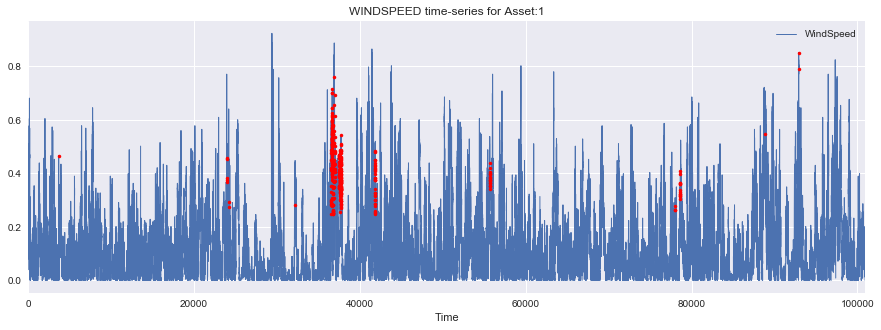

In [62]:
## TIME Series

feature = 'WindSpeed'
#feature = 'Power'
assets = len( df.Asset.unique())+1

for i in range(1,assets)[:1]:
    dfA = df[df.Asset==i]
    dfB = df_curt[df_curt.asset==i]
    fig, (ax1) = plt.subplots( figsize=(15,5) );
    dfA[feature].plot(ax=ax1, lw=1, legend=feature);
    dfB[feature].plot(style='r.-', lw=0, ax=ax1);
    ax1.set_title('WINDSPEED time-series for Asset:'+str(i))
    plt.show();

<IPython.core.display.Javascript object>


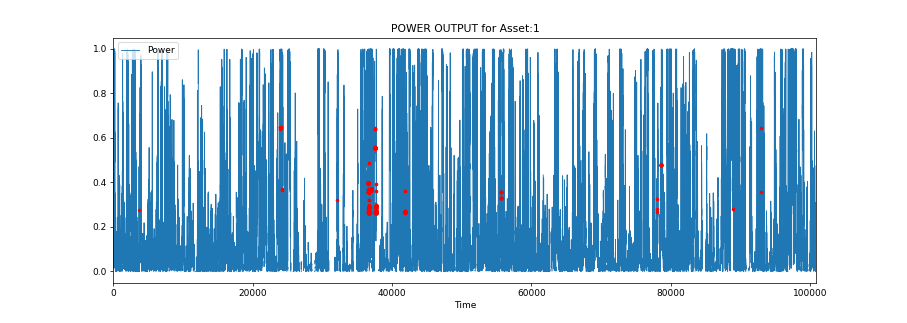

Text(0.5,1,'POWER OUTPUT for Asset:1')

In [125]:
## TIME Series

# feature = 'WindSpeed'
feature = 'Power'
assets = len( df.Asset.unique())+1

for i in range(1,assets)[:1]:
    dfA = df[df.Asset==i]
    dfB = df_curt[df_curt.asset==i]
    fig, (ax1) = plt.subplots( figsize=(14,5) )
    dfA[feature].plot(ax=ax1, lw=1, legend=feature);
    dfB[feature].plot(style='r.-', lw=0, ax=ax1);
    ax1.set_title('POWER OUTPUT for Asset:'+str(i))
    #plt.show()

In [ ]:
pandas.rolling_corr(arg1, arg2=None, window=None, min_periods=None, freq=None, center=False, pairwise=None, how=None)
HPI_data['TX12MA'] = pd.rolling_mean(HPI_data['TX'], 12)

### Method 2: Curtailments detection using rolling correlation

<IPython.core.display.Javascript object>


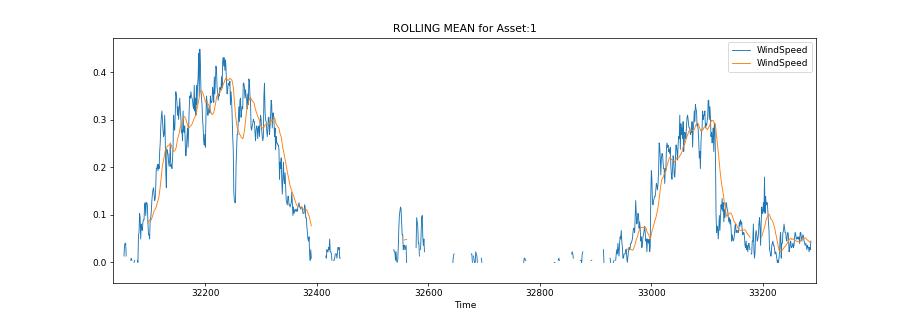

Text(0.5,1,'ROLLING MEAN for Asset:1')

In [117]:
feature = 'WindSpeed'
#feature = 'Power'
assets = len( df.Asset.unique())+1
for i in range(1,assets)[:1]:
    dfA = df[df.Asset==i]
    dfB = df_curt[df_curt.asset==i]
    dfC = dfA.rolling(window=20, center=False).mean()
    
    fig, (ax1) = plt.subplots( figsize=(14,5) )
    dfA[feature].plot(ax=ax1, lw=1, legend=feature)
    dfC[feature].plot(ax=ax1, lw=1, legend='rolling_mean')
    
    ax1.set_title('ROLLING MEAN for Asset:'+str(i))
    #plt.show()

<IPython.core.display.Javascript object>


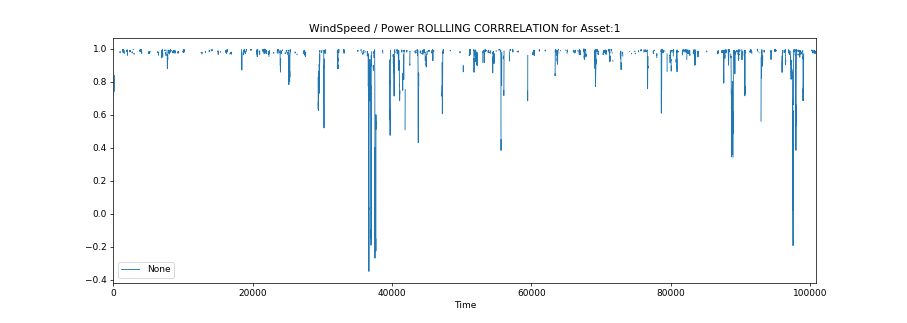

Text(0.5,1,'WindSpeed / Power ROLLLING CORRRELATION for Asset:1')

In [122]:
feature = 'WindSpeed'
#feature = 'Power'
assets = len( df.Asset.unique())+1
for i in range(1,assets)[:1]:
    dfA = df[df.Asset==i]
    #dfB = pd.rolling_corr(dfA.WindSpeed, dfA.Power, window=60, 
    #                          min_periods=None, freq=None, 
    #                          center=False, pairwise=None, how=None)
    
    dfB = dfA.WindSpeed.rolling(window=60,center=False).corr(other=dfA.Power)
    
    fig, (ax1) = plt.subplots( figsize=(14,5) )
    dfB.plot(ax=ax1, lw=1, legend='moving corr')
    ax1.set_title('WindSpeed / Power ROLLLING CORRRELATION for Asset:'+str(i))
    #plt.show()

<IPython.core.display.Javascript object>


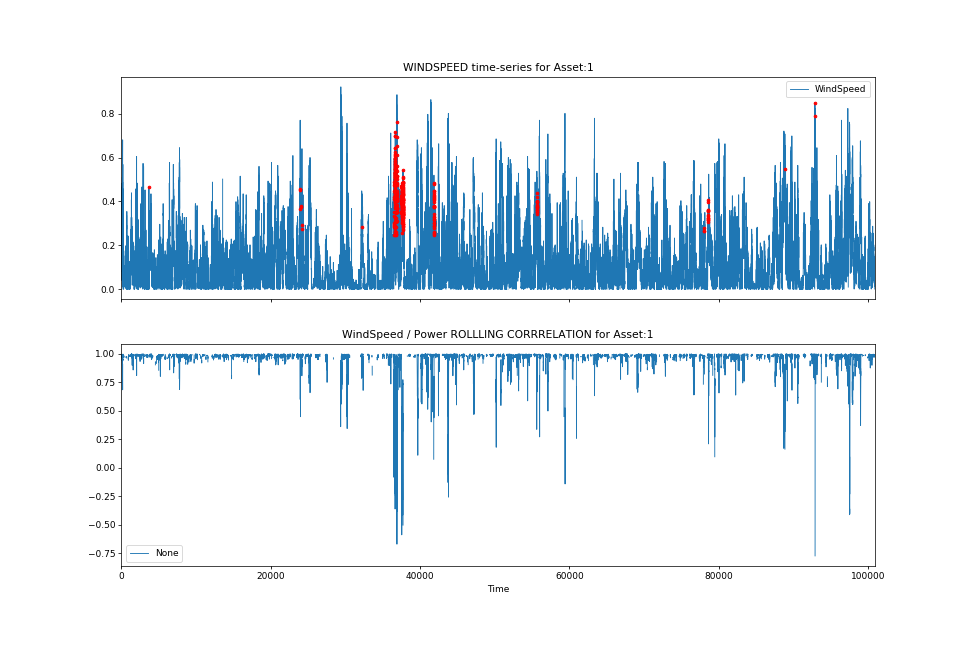

Text(0.5,1,'WINDSPEED time-series for Asset:1')

Text(0.5,1,'WindSpeed / Power ROLLLING CORRRELATION for Asset:1')

In [140]:
## TIME Series

feature = 'WindSpeed'
#feature = 'Power'
assets = len( df.Asset.unique())+1

for i in range(1,assets)[:1]:
    dfA = df[df.Asset==i]
    dfB = df_curt[df_curt.asset==i]
    dfC = dfA.WindSpeed.rolling(window=20,center=False).corr(other=dfA.Power)
    
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,10) )
    dfA[feature].plot(ax=ax1, lw=1, legend=feature);
    dfB[feature].plot(style='r.-', lw=0, ax=ax1);
    dfC.plot(ax=ax2, lw=1, legend='moving corr')
    
    ax1.set_title('WINDSPEED time-series for Asset:'+str(i))
    ax2.set_title('WindSpeed / Power ROLLLING CORRRELATION for Asset:'+str(i))
    #plt.show()

### ML FUNCTIONS

In [45]:
def ML_model(x_data, y_data):
    ''' Machine Learning Model Definition '''
    
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.05, random_state=0) 
    
    selector = 2
    
    if selector == 1:
        model = DecisionTreeRegressor(max_depth=7, random_state=0, splitter='best')
        
    elif selector == 2:
        model = GradientBoostingRegressor(n_estimators=100,  learning_rate=0.1, max_depth=7, random_state=0, loss='ls')
        
    elif selector==3:    
        model = RandomForestRegressor(max_depth=9,random_state=0)

    return x_train, x_test, y_train, y_test, model  